# Homework №3 - Сlustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from kmodes.kmodes import KModes
import featuretools as ft
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [ ]:
!pip install kmodes

In [ ]:
!pip install featuretools

In [3]:
df_num = pd.read_csv('my_data.tsv', sep='\t')

In [37]:
single_value_cols = df_num.columns[df_num.nunique() == 1]
df_single_value = df_num[single_value_cols]
df_num = df_num.drop(columns=single_value_cols)

In [38]:
len(df_num)

1526

In [75]:
df = pd.read_csv('df_normalized.tsv', sep='\t')

In [40]:
len(df)

2941

In [76]:
df_clear = df.dropna(subset=['ABC', 'fr_urea', 'BCUT2D_MRLOW', 'MinAbsPartialCharge', 'xlogp'])
print(df_clear.shape)

(1526, 2051)


In [42]:
single_value_col = df_clear.columns[df_clear.nunique() == 1]
df_single_value = df_clear[single_value_col]
df_clear = df_clear.drop(columns=single_value_col)

In [ ]:
pd.set_option('display.max_rows', None)
print(df.dtypes)

In [43]:
df_cat = df_clear.loc[:, ['DOI', 'Date', 'Journal', 'Title', 'Name', 'measurement_method', 'isomeric_smiles', 'specifier']]

In [44]:
df_cat.shape

(1526, 8)

## Clustering algorithm

Clustering can help identifying similarities and differences between groups of compounds based on their molecular properties, which can be useful for designing new compounds or predicting the properties of unknown compounds.

In [5]:
#Task: Choose one clustering algorithm suitable for your data and motivate your choice.
#Apply it, visualize and interpret your results. 

Based on a dataset i have, I decided to go with K-Means clustering algorithm. It works well for numeric data, and this data type is predominant. 

K-Means is an unsupervised learning algorithm that partitions data into k clusters, where each cluster represents a group of similar data points.

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 541, cost: 431381.0
Run 1, iteration: 2/100, moves: 406, cost: 427509.0
Run 1, iteration: 3/100, moves: 124, cost: 426870.0
Run 1, iteration: 4/100, moves: 101, cost: 425522.0
Run 1, iteration: 5/100, moves: 109, cost: 425005.0
Run 1, iteration: 6/100, moves: 31, cost: 424951.0
Run 1, iteration: 7/100, moves: 12, cost: 424947.0
Run 1, iteration: 8/100, moves: 1, cost: 424947.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 561, cost: 432945.0
Run 2, iteration: 2/100, moves: 303, cost: 430223.0
Run 2, iteration: 3/100, moves: 127, cost: 430134.0
Run 2, iteration: 4/100, moves: 27, cost: 430131.0
Run 2, iteration: 5/100, moves: 4, cost: 430129.0
Run 2, iteration: 6/100, moves: 0, cost: 430129.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 651, cost

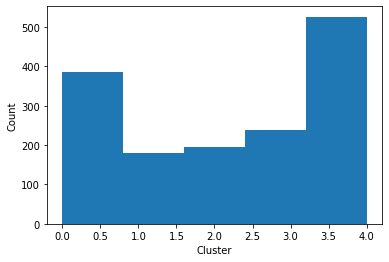

         measurement_error  measurement_method_encoded  \
cluster                                                  
0                 0.008327                    0.309585   
1                 0.010989                    0.261806   
2                 0.005756                    0.304209   
3                 0.002682                    0.305147   
4                 0.011678                    0.281131   

         isomeric_smiles_freq_encoded  raw_value  specifier_freq_encoded  \
cluster                                                                    
0                            0.093523   0.370178                0.554925   
1                            0.115185   0.363500                0.552818   
2                            0.155896   0.373586                0.541236   
3                            0.094304   0.386281                0.531917   
4                            0.167744   0.379375                0.610215   

              cid  MaxEStateIndex  MinEStateIndex  MaxAbsESt

C:\Users\bocha\AppData\Local\Temp\ipykernel_10696\88983378.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df_clear.groupby('cluster').mean())


In [46]:
# Preprocess the data
categorical_vars = df_cat.columns.values  # List of categorical variables
numeric_vars = df_num.columns.values  # List of numeric variables

# One-hot encode the categorical variables
enc = OneHotEncoder()
enc.fit(df_clear[categorical_vars])
df_encoded = pd.DataFrame(enc.transform(df_clear[categorical_vars]).toarray())

# Concatenate the one-hot encoded categorical variables with the numeric variables
df_preprocessed = pd.concat([df_encoded.reset_index(drop=True), df_clear[numeric_vars].reset_index(drop=True)], axis=1)

# Apply K-Modes clustering
n_clusters = 5  # Number of clusters to generate
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_preprocessed)

# Visualize the results
import matplotlib.pyplot as plt

plt.hist(clusters, bins=n_clusters)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Interpret the results
df_clear['cluster'] = clusters
print(df_clear.groupby('cluster').mean())

The data was divided into 5 clusters based on the combination of categorical and numeric descriptors.. The histogram shows the distribution of the data points across the clusters. The printed table shows the mean value of each variable in each cluster.

- Cluster 3 has the lowest mean value for 'measurement_error', indicating that compounds in this cluster have the most accurate measurements. The mean values of 'measurement_error' in clusters 0, 1, 2, and 4 are very similar, indicating that these clusters are relatively similar in terms of measurement errors.
- Cluster 4 has the highest isomeric smiles frequency and the highest complexity.
- Cluster 1 has the highest MaxEStateIndex and MaxAbsEStateIndex, as well as the highest molecular weight.
- The categorical variable 'measurement_method' seems to be one of the most important descriptors for clustering, as it has the highest encoded frequency in all clusters.

Overall, the KModes clustering algorithm has grouped the chemical compounds into clusters based on their categorical and numeric descriptors. The clusters seem to have some differences in the values of the numeric descriptors, which could indicate some structural similarities or differences between the chemical compounds in each cluster. These clusters could potentially be used to group similar chemical compounds together for further analysis or modeling.

## Feature engineering

One of the most popular and powerful approach is to use the Featuretools library in Python. This library uses concepts from relational databases to automatically generate new features based on existing features.

In [57]:
# Define the entity set
entityset = ft.EntitySet(id='MyEntitySet')
entityset.add_dataframe(dataframe_name='df_clear', dataframe=df_clear, index='index')

# Run deep feature synthesis to generate new features
features, feature_names = ft.dfs(entityset=entityset, target_dataframe_name='df_clear', max_depth=2)

# Selecting features that are highly correlated with the target variable
correlation_matrix = features.corr()
relevant_features = correlation_matrix['raw_value'].sort_values(ascending=False)[:50].index.tolist()

# Create a new dataframe with only the selected features
df_relevant = df_clear[relevant_features]

C:\Users\bocha\AppData\Local\Programs\Python\Python310\lib\site-packages\featuretools\entityset\entityset.py:1906: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
C:\Users\bocha\AppData\Local\Programs\Python\Python310\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
C:\Users\bocha\AppData\Local\Temp\ipykernel_10696\2536845524.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = features.corr()


In [58]:
df_relevant.shape

(1526, 50)

In [61]:
pd.set_option('display.max_columns', None)
df_relevant.head()

,raw_value,measurement_error,Chi3v,Chi4v,complexity,Chi3n,Chi2v,exact_mass,molecular_weight,LabuteASA,HeavyAtomCount,HeavyAtomMolWt,ExactMolWt,MolWt,Chi1,specifier_freq_encoded,NumValenceElectrons,Chi0,Chi2n,MolMR,PEOE_VSA10,Chi4n,Chi0v,tpsa,Chi1v,NumAliphaticRings,Chi0n,NOCount,measurement_method_encoded,Chi1n,BertzCT,TPSA,Kappa1,NumHAcceptors,SlogP_VSA2,NumAliphaticHeterocycles,NumHDonors,PEOE_VSA1,NumHeteroatoms,NHOHCount,NumSaturatedRings,RingCount,PEOE_VSA7,EState_VSA1,VSA_EState3,SMR_VSA4,fr_COO,fr_COO2,SMR_VSA1,SlogP_VSA3
0,0.211218,0.000000,0.000000,0.00000,0.000784,0.00000,0.006502,0.015428,0.015437,0.025492,0.024590,0.014014,0.015776,0.015784,0.024658,0.030622,0.031646,0.030287,0.012119,0.033333,0.000000,0.000000,0.035969,0.025964,0.030837,0.000000,0.035969,0.021739,0.000,0.030837,0.000462,0.026003,0.005324,0.021739,0.030936,0.000000,0.04,0.028406,0.021739,0.04,0.000000,0.00000,0.056704,0.000000,0.054867,0.000000,0.000000,0.00,0.022425,0.000000
1,0.425656,0.000000,0.000000,0.00000,0.008683,0.00000,0.010671,0.020327,0.020336,0.031716,0.032787,0.019616,0.020673,0.020682,0.030200,1.000000,0.037975,0.040023,0.019891,0.034769,0.000000,0.000000,0.039327,0.047943,0.027957,0.000000,0.039327,0.043478,0.000,0.027957,0.004528,0.047945,0.006241,0.021739,0.029252,0.000000,0.04,0.028406,0.043478,0.04,0.000000,0.00000,0.000000,0.018360,0.054297,0.000000,0.333333,0.25,0.043480,0.039757
2,0.328325,0.000000,0.000000,0.00000,0.010308,0.00000,0.027585,0.032568,0.032572,0.038067,0.040984,0.033255,0.032910,0.032913,0.034872,0.000957,0.050633,0.050346,0.017139,0.019871,0.000000,0.000000,0.049665,0.110797,0.066021,0.000000,0.034731,0.086957,0.000,0.022007,0.008342,0.110864,0.009191,0.086957,0.000000,0.000000,0.00,0.107056,0.108696,0.00,0.000000,0.00000,0.000000,0.024061,0.026660,0.000000,0.000000,0.00,0.084515,0.037854
3,0.314942,0.000000,0.083318,0.04083,0.156303,0.25976,0.161161,0.140243,0.140332,0.257180,0.245902,0.131764,0.140547,0.140637,0.256742,0.286124,0.243671,0.229369,0.300405,0.312015,0.138017,0.190941,0.286102,0.116838,0.318627,0.076923,0.286102,0.152174,0.125,0.318627,0.200281,0.116815,0.033841,0.152174,0.104175,0.076923,0.08,0.087820,0.152174,0.12,0.076923,0.15625,0.554816,0.000000,0.069416,0.095273,0.000000,0.00,0.020802,0.054270
4,0.215385,0.000191,0.000000,0.00000,0.000784,0.00000,0.006502,0.015428,0.015437,0.025492,0.024590,0.014014,0.015776,0.015784,0.024658,0.286124,0.031646,0.030287,0.012119,0.033333,0.000000,0.000000,0.035969,0.025964,0.030837,0.000000,0.035969,0.021739,0.250,0.030837,0.000462,0.026003,0.005324,0.021739,0.030936,0.000000,0.04,0.028406,0.021739,0.04,0.000000,0.00000,0.056704,0.000000,0.054867,0.000000,0.000000,0.00,0.022425,0.000000


Feature selection helps to identify the most important features that have the strongest relationship with the target variable, which can improve the accuracy of the model and reduce the risk of overfitting. Additionally, selecting the most important features can also help to reduce the computational cost and improve the efficiency of the model during training and prediction.

In [62]:
df_relevant.to_csv('df_relevant.tsv', sep='\t', index=False)

## ML

In [63]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_relevant.drop('raw_value', axis=1), df_relevant['raw_value'], test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2:.3f}')
print(f'Mean squared error: {mse:.3f}')

# Visualize feature importances
importances = model.coef_
feature_names = df_relevant.drop('raw_value', axis=1).columns
for feature_name, importance in zip(feature_names, importances):
    print(f'{feature_name}: {importance:.3f}')


R-squared: 0.026
Mean squared error: 0.067
measurement_error: 0.884
Chi3v: 5.229
Chi4v: -0.398
complexity: -0.600
Chi3n: 1.866
Chi2v: 2.751
exact_mass: -230.196
molecular_weight: 230.548
LabuteASA: -0.351
HeavyAtomCount: 34.109
HeavyAtomMolWt: -52.402
ExactMolWt: -101.343
MolWt: 159.659
Chi1: -19.177
specifier_freq_encoded: 0.121
NumValenceElectrons: -27.341
Chi0: -4.562
Chi2n: -3.963
MolMR: 10.642
PEOE_VSA10: 0.711
Chi4n: 0.995
Chi0v: -22.030
tpsa: 0.501
Chi1v: 1.640
NumAliphaticRings: -0.031
Chi0n: 15.182
NOCount: -2.119
measurement_method_encoded: 0.127
Chi1n: -2.619
BertzCT: -1.047
TPSA: -0.078
Kappa1: 41.949
NumHAcceptors: 0.750
SlogP_VSA2: 0.128
NumAliphaticHeterocycles: 0.979
NumHDonors: 1.942
PEOE_VSA1: 1.657
NumHeteroatoms: 4.008
NHOHCount: -2.457
NumSaturatedRings: -0.589
RingCount: -0.184
PEOE_VSA7: 0.063
EState_VSA1: -0.460
VSA_EState3: -0.577
SMR_VSA4: 0.212
fr_COO: 0.164
fr_COO2: 0.123
SMR_VSA1: 0.090
SlogP_VSA3: 0.112


The R-squared value of 0.026 indicates that the model explains only a small proportion of the variation in the target variable. The mean squared error of 0.067 indicates that the average squared difference between the predicted and actual values is 0.067. 

In [65]:
# Split the data into training and testing sets
X = df_relevant.drop('raw_value', axis=1)
y = df_relevant['raw_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the SVR model
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = svr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2:.3f}")
print(f"Mean squared error: {mse:.3f}")

R-squared: 0.100
Mean squared error: 0.062


The R-squared value of the Support Vector Regression model (0.1) is higher than the R-squared value of the Linear Regression model (0.026), indicating that the Support Vector Regression model is able to explain more of the variance in the data. Additionally, the mean squared error of the Support Vector Regression model (0.062) is lower than the mean squared error of the Linear Regression model (0.067), indicating that the Support Vector Regression model has a lower average squared error in its predictions. Overall, these results suggest that the Support Vector Regression model is a better fit for the data and is able to make more accurate predictions than the Linear Regression model.

In [4]:
df_relevant = pd.read_csv('df_relevant.tsv', sep='\t')

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_relevant.drop('raw_value', axis=1), 
                                                    df_relevant['raw_value'], 
                                                    test_size=0.2, 
                                                    random_state=42)

# Initialize and fit the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("Mean squared error:", mse)

R-squared: 0.27887739357854713
Mean squared error: 0.04985949590105546


The R-squared value of the Random Forest Regression model (0.279) is higher than the R-squared value of the Linear Regression model (0.026), indicating that the Random Forest Regression model is able to explain more of the variance in the data. Additionally, the mean squared error of the Random Forest Regression model (0.050) is lower than the mean squared error of the Linear Regression model (0.067), indicating that the Random Forest Regression model has a lower average squared error in its predictions. However, the R-squared value of the Random Forest Regression model is lower than the R-squared value of the Support Vector Regression model (0.1), indicating that the Support Vector Regression model is still a better fit for the data than the Random Forest Regression model.

In [ ]:
#!pip install lazypredict

In [71]:
#df_relevant = pd.read_csv('df_relevant.tsv', sep='\t')

In [ ]:
#from lazypredict.Supervised import LazyRegressor
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score, mean_squared_error

#target_variable = 'raw_value'

# Spliting data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(df_relevant.drop(target_variable, axis=1), 
                                                    df_relevant[target_variable], 
                                                    test_size=0.2, 
                                                    random_state=42)

# Initialize the LazyRegressor
#reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and train models
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the summary report
#print(models)